In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch.serialization import default_restore_location

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Load the GAN model

In [3]:
def load_GAN_models(restore_file):
    # load state_dict for args
    state_dict = torch.load(restore_file, map_location=lambda s, l: default_restore_location(s, "cpu"))

    # Extract args
    args = state_dict['args']

    # Initiate models
    G,D = models.build_model_gan(args)
    netG = G.to(device)
    netD = D.to(device)

    # Load state_dict
    netG.load_state_dict(state_dict['modelG'][0]) # Remove the [0] for future models
    netD.load_state_dict(state_dict['modelD'][0])
    return netG,netD, args

restore_file_GAN= "experiments/unet1d-Sep-01-23:17:43_GAN_only/checkpoints/checkpoint_best.pt"
restore_file_GANMSE= "experiments/unet1d-Sep-01-23:18:04_MSE/checkpoints/checkpoint_best.pt"

netG_GAN,netD_GAN,_ = load_GAN_models(restore_file_GAN)
netG_GANMSE,netD_GANMSE,args = load_GAN_models(restore_file_GANMSE)

## Retrain (Generator only)

In [6]:
class Args(object):
    def __init__(self):
        self.data_path= 'data'
        self.datasetG= 'masked_pwc'
        self.datasetD= 'pwc'
        self.batch_size= 128
        self.model= 'unet1d'
        self.modelG= 'unet1d'
        self.modelD= 'gan_discriminator'
        self.lr= 0.001
        self.num_epochs= 10
        self.n_data = 100000
        self.min_sep = 5
        self.valid_interval= 2
        self.save_interval= 1
        self.seed = 0
        self.output_dir= 'experiments'
        self.experiment_dir= 'experiments/retrain_gen'
        self.experiment= None

        self.resume_training= False
        self.restore_file= None

        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False

        self.in_channels= 1
        self.hidden_size = 64
        self.bias= False
        self.test_num = 0
        self.wtl2 = 0.5 # l2 loss weighting
        # UNET
        self.residual = False
args=Args()

In [57]:
global_step = -1
start_epoch = 0

optimizerG = torch.optim.Adam(netG_GANMSE.parameters(), lr=args.lr,betas=(0.5, 0.999))

train_loaderG, valid_loaderG, _ = data.build_dataset(args.datasetG,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)
train_loaderD, _, _ = data.build_dataset(args.datasetD,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss", "train_psnr", "train_ssim"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_psnr", "valid_ssim"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None


# TRAINING
fake_label = 0.
real_label = 1.
# fake_label = [0.,0.1]
# real_label = [0.9,1.]

G_losses = []
D_losses = []

# Determine whether or not MSE is being used, which alters the loss reporting
if args.wtl2 > 0:
    use_mse = True
else:
    use_mse = False

for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %10 == 0:
            optimizerG.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loaderG, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, ((clean, mask),real) in enumerate(zip(train_bar,train_loaderD)):

#         ###############################
#         # First train the discriminator
#         ###############################
#         netD.zero_grad()
#         real_cpu = real.to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,),real_label,device=device)
#         # Introducing label noise
# #         label = torch.rand((b_size,),device=device)*(real_label[1]-real_label[0])+real_label[0]

#         # Forward pass real batch through D
#         output = netD(real_cpu).view(-1)
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all-fake batch
        # Generate fake signal batch with G
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = netG_GANMSE(inputs,mask_inputs)
        fake = (1-mask_inputs)*raw_outputs + mask_inputs*inputs

#         label.fill_(fake_label)
#         # Introducing label noise
# #         label = torch.rand((b_size,),device=device)*(fake_label[1]-fake_label[0])+fake_label[0]

#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         errD = errD_real + errD_fake
#         # Update D
#         optimizerD.step()

        ###############################
        # Next, train the generator
        ###############################
        netG_GANMSE.zero_grad() # train() or zero_grad()?
        b_size = clean.shape[0]
        label = torch.full((b_size,),real_label,device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_GAN(fake).view(-1)

        if use_mse:
            # Calculate G's loss based on this output
            errG_D = criterion(output, label)
            # MSE Loss
            errG_l2 = F.mse_loss(fake, inputs, reduction="sum") / (inputs.size(0) * 2)
            errG =  (1-args.wtl2) * errG_D + args.wtl2 * errG_l2
        else:
            errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()


        # Output training stats
        if batch_id % 50 == 0:
            if use_mse:
                print('[%d/%d][%d/%d]\tLoss_G: %.4f + %.4f = %.4f\tD(G(z)): %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG), \
                     errG_D.item(), errG_l2, errG.item(), D_G_z2))
            else: 
                print('[%d/%d][%d/%d]\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG),
                     errG.item(), D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())


        global_step += 1

        # TO DO, only run loss on masked part of output
        # TO DO, incorporate MSE loss into GAN?
#         loss = F.mse_loss(outputs, inputs, reduction="sum") / (inputs.size(0) * 2)

        train_psnr = utils.psnr(fake, inputs)
        train_ssim = utils.ssim(fake, inputs)
        train_meters["train_loss"].update(errG.item())
        train_meters["train_psnr"].update(train_psnr.item())
        train_meters["train_ssim"].update(train_ssim.item())
        train_bar.log(dict(**train_meters, lr=optimizerG.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizerG.param_groups[0]["lr"], global_step)
            writer.add_scalar("loss/train", errG.item(), global_step)
            writer.add_scalar("psnr/train", train_psnr.item(), global_step)
            writer.add_scalar("ssim/train", train_ssim.item(), global_step)
            gradients = torch.cat([p.grad.view(-1) for p in netG_GANMSE.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()

    if epoch % args.valid_interval == 0:
        netG_GANMSE.eval()
        for meter in valid_meters.values():
            meter.reset()

        valid_bar = utils.ProgressBar(valid_loaderG)

        for sample_id, (clean, mask) in enumerate(valid_bar):
            with torch.no_grad():
                inputs = clean.to(device)
                mask_inputs = mask.to(device)
                # only use the mask part of the outputs
                raw_output = netG_GANMSE(inputs,mask_inputs)
                output = (1-mask_inputs)*raw_output + mask_inputs*inputs
                valid_psnr = utils.psnr(inputs, output)
                valid_meters["valid_psnr"].update(valid_psnr.item())
                valid_ssim = utils.ssim(inputs, output)
                valid_meters["valid_ssim"].update(valid_ssim.item())

        if writer is not None:
            writer.add_scalar("psnr/valid", valid_meters['valid_psnr'].avg, global_step)
            writer.add_scalar("ssim/valid", valid_meters['valid_ssim'].avg, global_step)
            sys.stdout.flush()
#             utils.save_checkpoint_GAN(args, global_step, netG, netD, optimizerG, optimizerD, score=valid_meters["valid_psnr"].avg, mode="max")

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizerG.param_groups[0]["lr"])))
logging.info(f"Done training!")

epoch 00:   0%|          | 0/782 [00:00<?, ?it/s, train_loss=3.010 (3.010), train_psnr=19.365 (19.365), train_ssim=0.847 (0.847), lr=1.0e-03]

[0/10][0/782]	Loss_G: 5.2194 + 0.7998 = 3.0096	D(G(z)): 0.0075


epoch 00:   7%|▋         | 52/782 [00:05<01:14,  9.78it/s, train_loss=2.394 (2.446), train_psnr=19.703 (20.920), train_ssim=0.847 (0.862), lr=1.0e-03]

[0/10][50/782]	Loss_G: 2.3245 + 0.9044 = 1.6144	D(G(z)): 0.1201


epoch 00:  13%|█▎        | 100/782 [00:10<01:09,  9.83it/s, train_loss=1.945 (1.246), train_psnr=20.492 (21.046), train_ssim=0.853 (0.858), lr=1.0e-03]

[0/10][100/782]	Loss_G: 1.5432 + 0.9487 = 1.2460	D(G(z)): 0.2373


epoch 00:  19%|█▉        | 152/782 [00:15<01:04,  9.78it/s, train_loss=1.662 (1.676), train_psnr=20.573 (21.019), train_ssim=0.851 (0.849), lr=1.0e-03]

[0/10][150/782]	Loss_G: 2.0129 + 0.8589 = 1.4359	D(G(z)): 0.1723


epoch 00:  26%|██▌       | 200/782 [00:20<01:00,  9.62it/s, train_loss=1.557 (1.769), train_psnr=20.792 (21.638), train_ssim=0.853 (0.857), lr=1.0e-03]

[0/10][200/782]	Loss_G: 2.8519 + 0.6852 = 1.7685	D(G(z)): 0.0732


epoch 00:  32%|███▏      | 251/782 [00:26<00:54,  9.72it/s, train_loss=1.509 (1.211), train_psnr=20.561 (20.297), train_ssim=0.852 (0.855), lr=1.0e-03]

[0/10][250/782]	Loss_G: 1.8381 + 0.8739 = 1.3560	D(G(z)): 0.2013


epoch 00:  38%|███▊      | 300/782 [00:31<00:49,  9.70it/s, train_loss=1.395 (1.197), train_psnr=20.886 (20.873), train_ssim=0.853 (0.853), lr=1.0e-03]

[0/10][300/782]	Loss_G: 1.5648 + 0.8293 = 1.1971	D(G(z)): 0.2484


epoch 00:  45%|████▌     | 352/782 [00:36<00:43,  9.78it/s, train_loss=1.274 (0.809), train_psnr=21.124 (20.566), train_ssim=0.855 (0.847), lr=1.0e-03]

[0/10][350/782]	Loss_G: 2.0566 + 0.8388 = 1.4477	D(G(z)): 0.1585


epoch 00:  51%|█████     | 400/782 [00:41<00:39,  9.71it/s, train_loss=1.223 (0.862), train_psnr=21.224 (20.442), train_ssim=0.856 (0.854), lr=1.0e-03]

[0/10][400/782]	Loss_G: 0.9905 + 0.7341 = 0.8623	D(G(z)): 0.4042


epoch 00:  58%|█████▊    | 452/782 [00:46<00:33,  9.83it/s, train_loss=1.168 (1.571), train_psnr=21.444 (22.091), train_ssim=0.858 (0.863), lr=1.0e-03]

[0/10][450/782]	Loss_G: 1.1161 + 0.7107 = 0.9134	D(G(z)): 0.3678


epoch 00:  64%|██████▍   | 500/782 [00:51<00:28,  9.75it/s, train_loss=1.162 (1.430), train_psnr=21.656 (21.762), train_ssim=0.858 (0.858), lr=1.0e-03]

[0/10][500/782]	Loss_G: 2.2634 + 0.5963 = 1.4298	D(G(z)): 0.1400


epoch 00:  71%|███████   | 552/782 [00:56<00:23,  9.86it/s, train_loss=1.135 (0.863), train_psnr=21.646 (22.356), train_ssim=0.859 (0.862), lr=1.0e-03]

[0/10][550/782]	Loss_G: 1.1648 + 0.7478 = 0.9563	D(G(z)): 0.3574


epoch 00:  77%|███████▋  | 600/782 [01:01<00:18,  9.84it/s, train_loss=1.099 (0.954), train_psnr=21.882 (23.075), train_ssim=0.860 (0.867), lr=1.0e-03]

[0/10][600/782]	Loss_G: 1.3305 + 0.5777 = 0.9541	D(G(z)): 0.3130


epoch 00:  83%|████████▎ | 652/782 [01:06<00:13,  9.85it/s, train_loss=1.067 (0.950), train_psnr=22.067 (21.637), train_ssim=0.861 (0.852), lr=1.0e-03]

[0/10][650/782]	Loss_G: 1.3765 + 0.8020 = 1.0892	D(G(z)): 0.3016


epoch 00:  90%|████████▉ | 700/782 [01:11<00:08,  9.75it/s, train_loss=1.041 (0.777), train_psnr=21.879 (21.577), train_ssim=0.860 (0.862), lr=1.0e-03]

[0/10][700/782]	Loss_G: 0.8777 + 0.6763 = 0.7770	D(G(z)): 0.4636


epoch 00:  96%|█████████▌| 752/782 [01:17<00:03,  9.81it/s, train_loss=0.994 (1.301), train_psnr=21.926 (22.457), train_ssim=0.859 (0.865), lr=1.0e-03]

[0/10][750/782]	Loss_G: 0.6438 + 0.6378 = 0.6408	D(G(z)): 0.5573


epoch 01:   0%|          | 1/782 [00:00<04:45,  2.74it/s, train_loss=1.115 (1.378), train_psnr=20.616 (21.973), train_ssim=0.848 (0.862), lr=1.0e-03]  

[1/10][0/782]	Loss_G: 1.2870 + 0.9329 = 1.1099	D(G(z)): 0.3238


epoch 01:   7%|▋         | 51/782 [00:05<01:12, 10.02it/s, train_loss=1.068 (1.280), train_psnr=21.360 (21.268), train_ssim=0.854 (0.850), lr=1.0e-03]

[1/10][50/782]	Loss_G: 1.4493 + 0.8316 = 1.1404	D(G(z)): 0.2821


epoch 01:  13%|█▎        | 101/782 [00:10<01:07, 10.08it/s, train_loss=1.020 (1.321), train_psnr=21.783 (21.781), train_ssim=0.858 (0.851), lr=1.0e-03]

[1/10][100/782]	Loss_G: 0.9185 + 0.7547 = 0.8366	D(G(z)): 0.4415


epoch 01:  19%|█▉        | 152/782 [00:15<01:02, 10.00it/s, train_loss=1.042 (1.331), train_psnr=21.664 (21.497), train_ssim=0.857 (0.853), lr=1.0e-03]

[1/10][150/782]	Loss_G: 1.8847 + 0.6426 = 1.2637	D(G(z)): 0.1797


epoch 01:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s, train_loss=0.995 (0.573), train_psnr=21.773 (20.893), train_ssim=0.860 (0.851), lr=1.0e-03]

[1/10][200/782]	Loss_G: 1.4260 + 0.5817 = 1.0038	D(G(z)): 0.2826


epoch 01:  32%|███▏      | 252/782 [00:25<00:54,  9.80it/s, train_loss=0.997 (0.693), train_psnr=21.883 (21.467), train_ssim=0.860 (0.859), lr=1.0e-03]

[1/10][250/782]	Loss_G: 2.4175 + 0.8076 = 1.6125	D(G(z)): 0.1175


epoch 01:  38%|███▊      | 301/782 [00:30<00:48, 10.00it/s, train_loss=0.972 (1.136), train_psnr=21.796 (22.033), train_ssim=0.859 (0.860), lr=1.0e-03]

[1/10][300/782]	Loss_G: 0.9304 + 0.6190 = 0.7747	D(G(z)): 0.4259


epoch 01:  45%|████▍     | 351/782 [00:35<00:42, 10.04it/s, train_loss=0.991 (1.277), train_psnr=21.806 (21.881), train_ssim=0.859 (0.865), lr=1.0e-03]

[1/10][350/782]	Loss_G: 0.9775 + 0.6582 = 0.8178	D(G(z)): 0.4174


epoch 01:  51%|█████▏    | 401/782 [00:40<00:37, 10.04it/s, train_loss=0.970 (0.658), train_psnr=21.842 (22.554), train_ssim=0.859 (0.865), lr=1.0e-03]

[1/10][400/782]	Loss_G: 0.7567 + 0.6291 = 0.6929	D(G(z)): 0.5011


epoch 01:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s, train_loss=1.023 (1.407), train_psnr=22.035 (22.282), train_ssim=0.860 (0.864), lr=1.0e-03]

[1/10][450/782]	Loss_G: 1.8585 + 0.6188 = 1.2387	D(G(z)): 0.1991


epoch 01:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s, train_loss=0.993 (1.201), train_psnr=22.173 (21.843), train_ssim=0.861 (0.862), lr=1.0e-03]

[1/10][500/782]	Loss_G: 2.1710 + 0.4747 = 1.3228	D(G(z)): 0.1358


epoch 01:  70%|███████   | 551/782 [00:55<00:23,  9.99it/s, train_loss=0.983 (0.841), train_psnr=22.374 (21.884), train_ssim=0.863 (0.864), lr=1.0e-03]

[1/10][550/782]	Loss_G: 1.0291 + 0.6483 = 0.8387	D(G(z)): 0.4079


epoch 01:  77%|███████▋  | 601/782 [01:00<00:18,  9.82it/s, train_loss=0.951 (1.228), train_psnr=22.391 (22.423), train_ssim=0.864 (0.868), lr=1.0e-03]

[1/10][600/782]	Loss_G: 0.7897 + 0.6650 = 0.7274	D(G(z)): 0.5053


epoch 01:  83%|████████▎ | 651/782 [01:05<00:13,  9.97it/s, train_loss=0.942 (0.617), train_psnr=22.575 (22.722), train_ssim=0.865 (0.865), lr=1.0e-03]

[1/10][650/782]	Loss_G: 0.9107 + 0.7161 = 0.8134	D(G(z)): 0.4594


epoch 01:  90%|████████▉ | 702/782 [01:10<00:08,  9.95it/s, train_loss=0.992 (0.737), train_psnr=22.173 (21.623), train_ssim=0.862 (0.863), lr=1.0e-03]

[1/10][700/782]	Loss_G: 1.9756 + 0.6196 = 1.2976	D(G(z)): 0.1770


epoch 01:  96%|█████████▌| 752/782 [01:15<00:03,  9.97it/s, train_loss=1.047 (0.868), train_psnr=21.938 (20.864), train_ssim=0.860 (0.855), lr=1.0e-03]

[1/10][750/782]	Loss_G: 1.2953 + 0.7197 = 1.0075	D(G(z)): 0.3104


epoch 02:   0%|          | 1/782 [00:00<04:32,  2.87it/s, train_loss=1.072 (0.618), train_psnr=23.386 (22.090), train_ssim=0.870 (0.860), lr=1.0e-03]  

[2/10][0/782]	Loss_G: 1.6311 + 0.5321 = 1.0816	D(G(z)): 0.2290


epoch 02:   7%|▋         | 52/782 [00:05<01:13,  9.89it/s, train_loss=1.001 (1.045), train_psnr=22.334 (20.750), train_ssim=0.863 (0.852), lr=1.0e-03]

[2/10][50/782]	Loss_G: 0.9740 + 0.8399 = 0.9069	D(G(z)): 0.4371


epoch 02:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s, train_loss=0.984 (1.080), train_psnr=22.311 (22.418), train_ssim=0.862 (0.864), lr=1.0e-03]

[2/10][100/782]	Loss_G: 1.3097 + 0.5491 = 0.9294	D(G(z)): 0.3298


epoch 02:  19%|█▉        | 151/782 [00:15<01:08,  9.16it/s, train_loss=1.006 (1.501), train_psnr=22.657 (24.420), train_ssim=0.864 (0.874), lr=1.0e-03]

[2/10][150/782]	Loss_G: 1.6842 + 0.7267 = 1.2055	D(G(z)): 0.2418


epoch 02:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s, train_loss=1.007 (0.919), train_psnr=23.179 (22.316), train_ssim=0.868 (0.863), lr=1.0e-03]

[2/10][200/782]	Loss_G: 1.8309 + 0.6168 = 1.2239	D(G(z)): 0.1918


epoch 02:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s, train_loss=0.942 (0.896), train_psnr=23.016 (22.688), train_ssim=0.868 (0.862), lr=1.0e-03]

[2/10][250/782]	Loss_G: 0.9398 + 0.5785 = 0.7591	D(G(z)): 0.4509


epoch 02:  39%|███▊      | 302/782 [00:30<00:47, 10.03it/s, train_loss=0.895 (0.618), train_psnr=22.687 (22.858), train_ssim=0.865 (0.867), lr=1.0e-03]

[2/10][300/782]	Loss_G: 1.0896 + 0.6422 = 0.8659	D(G(z)): 0.4004


epoch 02:  45%|████▌     | 352/782 [00:35<00:44,  9.66it/s, train_loss=0.889 (1.005), train_psnr=22.764 (23.135), train_ssim=0.866 (0.873), lr=1.0e-03]

[2/10][350/782]	Loss_G: 1.7130 + 0.5107 = 1.1118	D(G(z)): 0.2148


epoch 02:  51%|█████▏    | 401/782 [00:41<00:40,  9.40it/s, train_loss=1.001 (1.239), train_psnr=22.932 (23.298), train_ssim=0.867 (0.871), lr=1.0e-03]

[2/10][400/782]	Loss_G: 1.8526 + 0.9074 = 1.3800	D(G(z)): 0.2080


epoch 02:  58%|█████▊    | 452/782 [00:46<00:34,  9.61it/s, train_loss=0.983 (0.913), train_psnr=22.588 (22.701), train_ssim=0.865 (0.870), lr=1.0e-03]

[2/10][450/782]	Loss_G: 0.9792 + 0.5965 = 0.7879	D(G(z)): 0.4204


epoch 02:  64%|██████▍   | 502/782 [00:51<00:28,  9.71it/s, train_loss=0.927 (0.822), train_psnr=22.501 (22.209), train_ssim=0.864 (0.862), lr=1.0e-03]

[2/10][500/782]	Loss_G: 1.7696 + 0.7191 = 1.2444	D(G(z)): 0.2295


epoch 02:  71%|███████   | 552/782 [00:56<00:23,  9.74it/s, train_loss=0.900 (1.150), train_psnr=22.391 (23.896), train_ssim=0.864 (0.870), lr=1.0e-03]

[2/10][550/782]	Loss_G: 0.4689 + 1.0043 = 0.7366	D(G(z)): 0.7056


epoch 02:  77%|███████▋  | 601/782 [01:01<00:18,  9.95it/s, train_loss=0.906 (0.866), train_psnr=22.544 (22.453), train_ssim=0.865 (0.858), lr=1.0e-03]

[2/10][600/782]	Loss_G: 0.9718 + 0.6016 = 0.7867	D(G(z)): 0.4329


epoch 02:  83%|████████▎ | 652/782 [01:06<00:13,  9.75it/s, train_loss=0.890 (1.039), train_psnr=22.599 (23.126), train_ssim=0.865 (0.868), lr=1.0e-03]

[2/10][650/782]	Loss_G: 2.1541 + 0.4184 = 1.2862	D(G(z)): 0.1371


epoch 02:  90%|████████▉ | 702/782 [01:11<00:08,  9.91it/s, train_loss=0.915 (0.749), train_psnr=22.701 (21.941), train_ssim=0.865 (0.860), lr=1.0e-03]

[2/10][700/782]	Loss_G: 0.6514 + 0.8650 = 0.7582	D(G(z)): 0.6053


epoch 02:  96%|█████████▌| 752/782 [01:16<00:03,  9.68it/s, train_loss=0.863 (0.574), train_psnr=22.885 (22.540), train_ssim=0.867 (0.862), lr=1.0e-03]

[2/10][750/782]	Loss_G: 1.1612 + 0.5186 = 0.8399	D(G(z)): 0.3485


epoch 03:   0%|          | 1/782 [00:00<04:28,  2.90it/s, train_loss=0.965 (0.748), train_psnr=22.470 (21.448), train_ssim=0.857 (0.856), lr=1.0e-03]  

[3/10][0/782]	Loss_G: 0.4771 + 1.4615 = 0.9693	D(G(z)): 0.7378


epoch 03:   7%|▋         | 51/782 [00:05<01:13,  9.98it/s, train_loss=0.895 (0.845), train_psnr=22.922 (23.204), train_ssim=0.865 (0.869), lr=1.0e-03]

[3/10][50/782]	Loss_G: 0.5865 + 0.6273 = 0.6069	D(G(z)): 0.6200


epoch 03:  13%|█▎        | 102/782 [00:10<01:08,  9.97it/s, train_loss=0.879 (0.833), train_psnr=23.125 (23.462), train_ssim=0.867 (0.873), lr=1.0e-03]

[3/10][100/782]	Loss_G: 1.0590 + 0.7027 = 0.8808	D(G(z)): 0.4424


epoch 03:  19%|█▉        | 152/782 [00:15<01:03,  9.93it/s, train_loss=0.822 (0.796), train_psnr=23.102 (22.684), train_ssim=0.868 (0.865), lr=1.0e-03]

[3/10][150/782]	Loss_G: 1.6416 + 0.4727 = 1.0572	D(G(z)): 0.2248


epoch 03:  26%|██▌       | 202/782 [00:20<00:58,  9.97it/s, train_loss=0.929 (1.391), train_psnr=22.961 (24.170), train_ssim=0.867 (0.881), lr=1.0e-03]

[3/10][200/782]	Loss_G: 0.9243 + 0.9480 = 0.9361	D(G(z)): 0.4775


epoch 03:  32%|███▏      | 252/782 [00:25<00:53,  9.93it/s, train_loss=0.861 (0.775), train_psnr=23.222 (22.980), train_ssim=0.869 (0.859), lr=1.0e-03]

[3/10][250/782]	Loss_G: 1.3389 + 0.5681 = 0.9535	D(G(z)): 0.3064


epoch 03:  38%|███▊      | 301/782 [00:30<00:48, 10.01it/s, train_loss=0.860 (1.473), train_psnr=23.280 (21.982), train_ssim=0.869 (0.858), lr=1.0e-03]

[3/10][300/782]	Loss_G: 1.4976 + 0.7671 = 1.1323	D(G(z)): 0.2651


epoch 03:  45%|████▍     | 351/782 [00:35<00:42, 10.04it/s, train_loss=0.965 (0.978), train_psnr=22.770 (23.345), train_ssim=0.865 (0.864), lr=1.0e-03]

[3/10][350/782]	Loss_G: 1.2449 + 0.6345 = 0.9397	D(G(z)): 0.3194


epoch 03:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s, train_loss=0.981 (1.131), train_psnr=22.788 (23.574), train_ssim=0.866 (0.866), lr=1.0e-03]

[3/10][400/782]	Loss_G: 1.3679 + 0.5980 = 0.9830	D(G(z)): 0.2984


epoch 03:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s, train_loss=0.953 (1.124), train_psnr=22.527 (22.005), train_ssim=0.864 (0.860), lr=1.0e-03]

[3/10][450/782]	Loss_G: 0.9345 + 0.9981 = 0.9663	D(G(z)): 0.4528


epoch 03:  64%|██████▍   | 501/782 [00:50<00:28,  9.96it/s, train_loss=0.921 (0.758), train_psnr=22.654 (23.547), train_ssim=0.864 (0.866), lr=1.0e-03]

[3/10][500/782]	Loss_G: 0.9599 + 0.5159 = 0.7379	D(G(z)): 0.4288


epoch 03:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s, train_loss=0.894 (0.838), train_psnr=22.921 (23.269), train_ssim=0.866 (0.879), lr=1.0e-03]

[3/10][550/782]	Loss_G: 0.6513 + 0.8515 = 0.7514	D(G(z)): 0.5934


epoch 03:  77%|███████▋  | 602/782 [01:00<00:18,  9.98it/s, train_loss=0.860 (1.167), train_psnr=22.926 (23.827), train_ssim=0.867 (0.872), lr=1.0e-03]

[3/10][600/782]	Loss_G: 0.3612 + 0.7150 = 0.5381	D(G(z)): 0.7758


epoch 03:  83%|████████▎ | 651/782 [01:05<00:12, 10.08it/s, train_loss=0.900 (0.830), train_psnr=23.037 (23.943), train_ssim=0.867 (0.880), lr=1.0e-03]

[3/10][650/782]	Loss_G: 0.5732 + 0.6445 = 0.6088	D(G(z)): 0.5893


epoch 03:  90%|████████▉ | 702/782 [01:10<00:07, 10.07it/s, train_loss=0.921 (0.743), train_psnr=22.714 (22.340), train_ssim=0.865 (0.863), lr=1.0e-03]

[3/10][700/782]	Loss_G: 1.3919 + 0.6494 = 1.0206	D(G(z)): 0.2979


epoch 03:  96%|█████████▌| 752/782 [01:15<00:03,  9.96it/s, train_loss=0.914 (0.789), train_psnr=22.821 (21.561), train_ssim=0.866 (0.854), lr=1.0e-03]

[3/10][750/782]	Loss_G: 0.7652 + 0.9952 = 0.8802	D(G(z)): 0.5776


epoch 04:   0%|          | 1/782 [00:00<04:53,  2.66it/s, train_loss=1.366 (0.726), train_psnr=23.198 (22.731), train_ssim=0.864 (0.865), lr=1.0e-03]  

[4/10][0/782]	Loss_G: 2.0616 + 0.6958 = 1.3787	D(G(z)): 0.1668


epoch 04:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s, train_loss=1.099 (0.746), train_psnr=23.140 (23.919), train_ssim=0.866 (0.873), lr=1.0e-03]

[4/10][50/782]	Loss_G: 2.0180 + 0.7965 = 1.4072	D(G(z)): 0.1990


epoch 04:  13%|█▎        | 102/782 [00:10<01:08,  9.92it/s, train_loss=0.922 (0.643), train_psnr=23.329 (23.212), train_ssim=0.868 (0.868), lr=1.0e-03]

[4/10][100/782]	Loss_G: 0.3292 + 0.8932 = 0.6112	D(G(z)): 0.7697


epoch 04:  19%|█▉        | 152/782 [00:15<01:03,  9.93it/s, train_loss=0.850 (0.954), train_psnr=23.473 (23.402), train_ssim=0.870 (0.872), lr=1.0e-03]

[4/10][150/782]	Loss_G: 0.7960 + 0.5426 = 0.6693	D(G(z)): 0.4992


epoch 04:  26%|██▌       | 201/782 [00:20<00:58,  9.97it/s, train_loss=0.852 (1.496), train_psnr=23.468 (23.767), train_ssim=0.870 (0.876), lr=1.0e-03]

[4/10][200/782]	Loss_G: 0.8563 + 0.7754 = 0.8159	D(G(z)): 0.5227


epoch 04:  32%|███▏      | 252/782 [00:25<00:54,  9.76it/s, train_loss=0.813 (0.545), train_psnr=23.620 (23.635), train_ssim=0.871 (0.867), lr=1.0e-03]

[4/10][250/782]	Loss_G: 0.6260 + 0.5574 = 0.5917	D(G(z)): 0.5958


epoch 04:  39%|███▊      | 302/782 [00:30<00:48,  9.95it/s, train_loss=0.843 (0.758), train_psnr=23.806 (24.376), train_ssim=0.873 (0.875), lr=1.0e-03]

[4/10][300/782]	Loss_G: 0.7702 + 0.7809 = 0.7755	D(G(z)): 0.5406


epoch 04:  45%|████▌     | 352/782 [00:35<00:42, 10.03it/s, train_loss=0.784 (0.780), train_psnr=23.331 (22.142), train_ssim=0.869 (0.860), lr=1.0e-03]

[4/10][350/782]	Loss_G: 1.1461 + 0.6959 = 0.9210	D(G(z)): 0.3582


epoch 04:  51%|█████▏    | 402/782 [00:40<00:39,  9.74it/s, train_loss=0.790 (0.775), train_psnr=23.354 (23.015), train_ssim=0.870 (0.869), lr=1.0e-03]

[4/10][400/782]	Loss_G: 1.3404 + 0.7326 = 1.0365	D(G(z)): 0.3221


epoch 04:  58%|█████▊    | 451/782 [00:45<00:33,  9.94it/s, train_loss=0.798 (0.686), train_psnr=23.433 (23.735), train_ssim=0.870 (0.874), lr=1.0e-03]

[4/10][450/782]	Loss_G: 1.8661 + 0.5638 = 1.2149	D(G(z)): 0.1824


epoch 04:  64%|██████▍   | 502/782 [00:50<00:28,  9.92it/s, train_loss=0.837 (0.747), train_psnr=23.689 (24.398), train_ssim=0.872 (0.878), lr=1.0e-03]

[4/10][500/782]	Loss_G: 1.0108 + 1.0827 = 1.0468	D(G(z)): 0.4876


epoch 04:  70%|███████   | 551/782 [00:55<00:23,  9.92it/s, train_loss=0.878 (0.818), train_psnr=23.917 (24.229), train_ssim=0.873 (0.875), lr=1.0e-03]

[4/10][550/782]	Loss_G: 0.7373 + 0.7423 = 0.7398	D(G(z)): 0.5629


epoch 04:  77%|███████▋  | 602/782 [01:00<00:18,  9.89it/s, train_loss=0.842 (0.913), train_psnr=23.860 (24.403), train_ssim=0.873 (0.876), lr=1.0e-03]

[4/10][600/782]	Loss_G: 1.5653 + 0.7052 = 1.1353	D(G(z)): 0.2724


epoch 04:  83%|████████▎ | 652/782 [01:05<00:13,  9.95it/s, train_loss=0.897 (0.721), train_psnr=23.842 (23.258), train_ssim=0.873 (0.866), lr=1.0e-03]

[4/10][650/782]	Loss_G: 0.7521 + 0.5969 = 0.6745	D(G(z)): 0.5549


epoch 04:  90%|████████▉ | 702/782 [01:10<00:08,  9.94it/s, train_loss=0.845 (0.711), train_psnr=23.825 (22.651), train_ssim=0.872 (0.864), lr=1.0e-03]

[4/10][700/782]	Loss_G: 1.1041 + 0.7664 = 0.9353	D(G(z)): 0.4209


epoch 04:  96%|█████████▌| 752/782 [01:15<00:03,  9.91it/s, train_loss=0.789 (0.851), train_psnr=23.848 (23.545), train_ssim=0.873 (0.868), lr=1.0e-03]

[4/10][750/782]	Loss_G: 1.2664 + 0.4779 = 0.8721	D(G(z)): 0.3217


epoch 05:   0%|          | 1/782 [00:00<04:35,  2.83it/s, train_loss=0.582 (0.784), train_psnr=24.595 (24.993), train_ssim=0.883 (0.881), lr=1.0e-03]  

[5/10][0/782]	Loss_G: 0.2797 + 0.8768 = 0.5782	D(G(z)): 0.8154


epoch 05:   7%|▋         | 52/782 [00:05<01:15,  9.73it/s, train_loss=0.703 (0.631), train_psnr=24.299 (24.263), train_ssim=0.877 (0.880), lr=1.0e-03]

[5/10][50/782]	Loss_G: 0.3158 + 0.9767 = 0.6462	D(G(z)): 0.8318


epoch 05:  13%|█▎        | 102/782 [00:10<01:09,  9.78it/s, train_loss=0.741 (1.141), train_psnr=24.209 (23.846), train_ssim=0.876 (0.874), lr=1.0e-03]

[5/10][100/782]	Loss_G: 0.2866 + 0.7489 = 0.5178	D(G(z)): 0.7633


epoch 05:  19%|█▉        | 151/782 [00:15<01:06,  9.43it/s, train_loss=0.791 (0.896), train_psnr=23.828 (23.762), train_ssim=0.873 (0.876), lr=1.0e-03]

[5/10][150/782]	Loss_G: 0.5187 + 0.9776 = 0.7481	D(G(z)): 0.6823


epoch 05:  26%|██▌       | 202/782 [00:20<00:59,  9.82it/s, train_loss=0.785 (0.776), train_psnr=23.897 (24.697), train_ssim=0.873 (0.878), lr=1.0e-03]

[5/10][200/782]	Loss_G: 0.5019 + 0.6081 = 0.5550	D(G(z)): 0.6607


epoch 05:  32%|███▏      | 252/782 [00:25<00:54,  9.78it/s, train_loss=0.840 (0.840), train_psnr=24.075 (23.551), train_ssim=0.873 (0.873), lr=1.0e-03]

[5/10][250/782]	Loss_G: 0.6692 + 0.9624 = 0.8158	D(G(z)): 0.6053


epoch 05:  39%|███▊      | 302/782 [00:31<00:49,  9.78it/s, train_loss=0.873 (1.207), train_psnr=24.176 (24.303), train_ssim=0.875 (0.878), lr=1.0e-03]

[5/10][300/782]	Loss_G: 0.1489 + 0.9770 = 0.5629	D(G(z)): 0.9245


epoch 05:  45%|████▌     | 352/782 [00:36<00:44,  9.74it/s, train_loss=0.797 (0.507), train_psnr=24.197 (24.235), train_ssim=0.875 (0.872), lr=1.0e-03]

[5/10][350/782]	Loss_G: 0.8550 + 1.1775 = 1.0162	D(G(z)): 0.5355


epoch 05:  51%|█████▏    | 401/782 [00:41<00:39,  9.67it/s, train_loss=0.808 (0.752), train_psnr=24.362 (24.008), train_ssim=0.876 (0.877), lr=1.0e-03]

[5/10][400/782]	Loss_G: 0.2010 + 0.7619 = 0.4814	D(G(z)): 0.8846


epoch 05:  58%|█████▊    | 452/782 [00:46<00:33,  9.71it/s, train_loss=0.800 (0.676), train_psnr=24.216 (23.904), train_ssim=0.875 (0.869), lr=1.0e-03]

[5/10][450/782]	Loss_G: 0.4882 + 0.6329 = 0.5606	D(G(z)): 0.6999


epoch 05:  64%|██████▍   | 502/782 [00:51<00:28,  9.68it/s, train_loss=0.835 (1.249), train_psnr=23.958 (23.445), train_ssim=0.874 (0.866), lr=1.0e-03]

[5/10][500/782]	Loss_G: 2.3046 + 0.6216 = 1.4631	D(G(z)): 0.1209


epoch 05:  71%|███████   | 552/782 [00:56<00:23,  9.60it/s, train_loss=0.806 (0.687), train_psnr=23.682 (24.322), train_ssim=0.871 (0.877), lr=1.0e-03]

[5/10][550/782]	Loss_G: 1.0186 + 0.3704 = 0.6945	D(G(z)): 0.4114


epoch 05:  77%|███████▋  | 602/782 [01:01<00:18,  9.79it/s, train_loss=0.820 (1.447), train_psnr=23.646 (23.954), train_ssim=0.871 (0.876), lr=1.0e-03]

[5/10][600/782]	Loss_G: 0.3165 + 0.8082 = 0.5624	D(G(z)): 0.7528


epoch 05:  83%|████████▎ | 652/782 [01:06<00:13,  9.71it/s, train_loss=0.789 (0.743), train_psnr=23.432 (23.097), train_ssim=0.870 (0.859), lr=1.0e-03]

[5/10][650/782]	Loss_G: 0.4684 + 0.6909 = 0.5797	D(G(z)): 0.6822


epoch 05:  90%|████████▉ | 702/782 [01:11<00:08,  9.86it/s, train_loss=0.792 (0.833), train_psnr=23.635 (24.754), train_ssim=0.871 (0.882), lr=1.0e-03]

[5/10][700/782]	Loss_G: 0.4079 + 0.7847 = 0.5963	D(G(z)): 0.7288


epoch 05:  96%|█████████▌| 751/782 [01:17<00:03,  9.94it/s, train_loss=0.774 (0.711), train_psnr=23.830 (23.878), train_ssim=0.873 (0.875), lr=1.0e-03]

[5/10][750/782]	Loss_G: 0.5718 + 0.9986 = 0.7852	D(G(z)): 0.6594


epoch 06:   0%|          | 1/782 [00:00<05:13,  2.49it/s, train_loss=0.648 (0.523), train_psnr=25.047 (22.713), train_ssim=0.883 (0.877), lr=1.0e-03]  

[6/10][0/782]	Loss_G: 0.8584 + 0.4433 = 0.6508	D(G(z)): 0.4797


epoch 06:   7%|▋         | 51/782 [00:05<01:14,  9.84it/s, train_loss=0.751 (0.511), train_psnr=24.339 (22.295), train_ssim=0.877 (0.863), lr=1.0e-03]

[6/10][50/782]	Loss_G: 0.3423 + 0.8303 = 0.5863	D(G(z)): 0.7541


epoch 06:  13%|█▎        | 102/782 [00:11<01:19,  8.56it/s, train_loss=0.721 (0.636), train_psnr=24.149 (24.163), train_ssim=0.876 (0.871), lr=1.0e-03]

[6/10][100/782]	Loss_G: 0.6579 + 0.9031 = 0.7805	D(G(z)): 0.6500


epoch 06:  19%|█▉        | 151/782 [00:16<01:05,  9.66it/s, train_loss=0.768 (0.904), train_psnr=24.322 (24.176), train_ssim=0.876 (0.872), lr=1.0e-03]

[6/10][150/782]	Loss_G: 0.7453 + 0.8254 = 0.7854	D(G(z)): 0.5634


epoch 06:  26%|██▌       | 201/782 [00:21<00:58,  9.93it/s, train_loss=0.858 (1.043), train_psnr=24.072 (23.233), train_ssim=0.875 (0.867), lr=1.0e-03]

[6/10][200/782]	Loss_G: 1.2645 + 0.6051 = 0.9348	D(G(z)): 0.3323


epoch 06:  32%|███▏      | 251/782 [00:26<00:52, 10.02it/s, train_loss=0.776 (0.462), train_psnr=23.868 (23.552), train_ssim=0.874 (0.870), lr=1.0e-03]

[6/10][250/782]	Loss_G: 0.4601 + 0.7348 = 0.5974	D(G(z)): 0.6988


epoch 06:  39%|███▊      | 302/782 [00:31<00:48,  9.92it/s, train_loss=0.777 (0.609), train_psnr=23.461 (23.001), train_ssim=0.871 (0.873), lr=1.0e-03]

[6/10][300/782]	Loss_G: 0.8652 + 0.8500 = 0.8576	D(G(z)): 0.4979


epoch 06:  45%|████▌     | 352/782 [00:36<00:44,  9.57it/s, train_loss=0.808 (0.912), train_psnr=23.574 (24.223), train_ssim=0.872 (0.881), lr=1.0e-03]

[6/10][350/782]	Loss_G: 0.8663 + 0.9531 = 0.9097	D(G(z)): 0.5271


epoch 06:  51%|█████▏    | 401/782 [00:41<00:40,  9.48it/s, train_loss=0.812 (0.573), train_psnr=23.876 (24.167), train_ssim=0.874 (0.869), lr=1.0e-03]

[6/10][400/782]	Loss_G: 0.6564 + 0.6606 = 0.6585	D(G(z)): 0.5690


epoch 06:  58%|█████▊    | 452/782 [00:47<00:35,  9.38it/s, train_loss=0.825 (0.724), train_psnr=24.059 (23.614), train_ssim=0.875 (0.872), lr=1.0e-03]

[6/10][450/782]	Loss_G: 0.3070 + 0.7676 = 0.5373	D(G(z)): 0.8073


epoch 06:  64%|██████▍   | 502/782 [00:52<00:28,  9.69it/s, train_loss=0.754 (1.036), train_psnr=23.898 (24.053), train_ssim=0.874 (0.876), lr=1.0e-03]

[6/10][500/782]	Loss_G: 0.3590 + 0.7306 = 0.5448	D(G(z)): 0.7183


epoch 06:  71%|███████   | 552/782 [00:57<00:23,  9.66it/s, train_loss=0.837 (0.675), train_psnr=24.304 (24.316), train_ssim=0.876 (0.880), lr=1.0e-03]

[6/10][550/782]	Loss_G: 0.7679 + 0.8372 = 0.8025	D(G(z)): 0.5757


epoch 06:  77%|███████▋  | 602/782 [01:02<00:18,  9.73it/s, train_loss=0.786 (0.548), train_psnr=24.192 (24.640), train_ssim=0.875 (0.873), lr=1.0e-03]

[6/10][600/782]	Loss_G: 1.4846 + 0.6709 = 1.0777	D(G(z)): 0.2935


epoch 06:  83%|████████▎ | 651/782 [01:07<00:13,  9.65it/s, train_loss=0.715 (0.545), train_psnr=24.207 (23.739), train_ssim=0.876 (0.877), lr=1.0e-03]

[6/10][650/782]	Loss_G: 0.9501 + 0.5309 = 0.7405	D(G(z)): 0.4232


epoch 06:  90%|████████▉ | 702/782 [01:12<00:08,  9.78it/s, train_loss=0.700 (0.885), train_psnr=24.332 (23.500), train_ssim=0.878 (0.875), lr=1.0e-03]

[6/10][700/782]	Loss_G: 1.3762 + 0.6603 = 1.0182	D(G(z)): 0.3390


epoch 06:  96%|█████████▌| 751/782 [01:17<00:03,  9.69it/s, train_loss=0.789 (0.997), train_psnr=23.991 (23.897), train_ssim=0.874 (0.869), lr=1.0e-03]

[6/10][750/782]	Loss_G: 1.0577 + 0.7287 = 0.8932	D(G(z)): 0.4130


epoch 07:   0%|          | 1/782 [00:00<04:54,  2.65it/s, train_loss=0.595 (0.568), train_psnr=23.353 (25.310), train_ssim=0.866 (0.893), lr=1.0e-03]  

[7/10][0/782]	Loss_G: 0.5583 + 0.6323 = 0.5953	D(G(z)): 0.6439


epoch 07:   7%|▋         | 52/782 [00:05<01:15,  9.67it/s, train_loss=0.701 (0.757), train_psnr=23.804 (26.040), train_ssim=0.872 (0.888), lr=1.0e-03]

[7/10][50/782]	Loss_G: 1.3705 + 0.5693 = 0.9699	D(G(z)): 0.2977


epoch 07:  13%|█▎        | 102/782 [00:10<01:10,  9.71it/s, train_loss=0.753 (0.948), train_psnr=23.900 (24.234), train_ssim=0.873 (0.872), lr=1.0e-03]

[7/10][100/782]	Loss_G: 1.3450 + 0.5468 = 0.9459	D(G(z)): 0.3044


epoch 07:  19%|█▉        | 152/782 [00:15<01:04,  9.75it/s, train_loss=0.763 (0.928), train_psnr=24.264 (25.360), train_ssim=0.876 (0.883), lr=1.0e-03]

[7/10][150/782]	Loss_G: 2.0205 + 0.4564 = 1.2385	D(G(z)): 0.1593


epoch 07:  26%|██▌       | 202/782 [00:21<00:58,  9.85it/s, train_loss=0.751 (0.780), train_psnr=24.069 (23.562), train_ssim=0.875 (0.866), lr=1.0e-03]

[7/10][200/782]	Loss_G: 0.5187 + 0.9255 = 0.7221	D(G(z)): 0.6685


epoch 07:  32%|███▏      | 252/782 [00:26<00:54,  9.76it/s, train_loss=0.735 (0.562), train_psnr=23.971 (22.322), train_ssim=0.874 (0.864), lr=1.0e-03]

[7/10][250/782]	Loss_G: 0.3614 + 1.0488 = 0.7051	D(G(z)): 0.7941


epoch 07:  39%|███▊      | 302/782 [00:31<00:49,  9.72it/s, train_loss=0.864 (0.779), train_psnr=23.947 (22.407), train_ssim=0.873 (0.866), lr=1.0e-03]

[7/10][300/782]	Loss_G: 1.1564 + 0.8581 = 1.0072	D(G(z)): 0.3635


epoch 07:  45%|████▌     | 352/782 [00:36<00:44,  9.64it/s, train_loss=0.864 (0.923), train_psnr=23.553 (21.895), train_ssim=0.871 (0.860), lr=1.0e-03]

[7/10][350/782]	Loss_G: 0.5222 + 0.7136 = 0.6179	D(G(z)): 0.6611


epoch 07:  51%|█████▏    | 402/782 [00:41<00:38,  9.78it/s, train_loss=0.878 (0.870), train_psnr=23.747 (24.726), train_ssim=0.872 (0.882), lr=1.0e-03]

[7/10][400/782]	Loss_G: 0.4931 + 0.6716 = 0.5823	D(G(z)): 0.7190


epoch 07:  58%|█████▊    | 452/782 [00:46<00:34,  9.46it/s, train_loss=0.811 (0.526), train_psnr=23.886 (22.205), train_ssim=0.874 (0.866), lr=1.0e-03]

[7/10][450/782]	Loss_G: 0.6253 + 0.5503 = 0.5878	D(G(z)): 0.6029


epoch 07:  64%|██████▍   | 502/782 [00:51<00:30,  9.12it/s, train_loss=0.831 (0.762), train_psnr=23.992 (24.029), train_ssim=0.874 (0.879), lr=1.0e-03]

[7/10][500/782]	Loss_G: 0.8963 + 0.6144 = 0.7554	D(G(z)): 0.4656


epoch 07:  71%|███████   | 552/782 [00:56<00:23,  9.74it/s, train_loss=0.812 (1.134), train_psnr=23.825 (23.159), train_ssim=0.874 (0.871), lr=1.0e-03]

[7/10][550/782]	Loss_G: 1.0127 + 0.9169 = 0.9648	D(G(z)): 0.4103


epoch 07:  77%|███████▋  | 602/782 [01:02<00:18,  9.77it/s, train_loss=0.787 (0.625), train_psnr=23.725 (23.668), train_ssim=0.874 (0.871), lr=1.0e-03]

[7/10][600/782]	Loss_G: 0.6419 + 0.6942 = 0.6681	D(G(z)): 0.5630


epoch 07:  83%|████████▎ | 652/782 [01:07<00:13,  9.76it/s, train_loss=0.767 (0.573), train_psnr=23.733 (23.077), train_ssim=0.874 (0.873), lr=1.0e-03]

[7/10][650/782]	Loss_G: 1.0869 + 0.6744 = 0.8807	D(G(z)): 0.4016


epoch 07:  90%|████████▉ | 701/782 [01:12<00:08,  9.77it/s, train_loss=0.992 (0.784), train_psnr=23.850 (23.976), train_ssim=0.873 (0.876), lr=1.0e-03]

[7/10][700/782]	Loss_G: 0.3972 + 0.7705 = 0.5838	D(G(z)): 0.7612


epoch 07:  96%|█████████▌| 751/782 [01:17<00:03,  9.79it/s, train_loss=0.969 (0.608), train_psnr=24.039 (23.649), train_ssim=0.874 (0.875), lr=1.0e-03]

[7/10][750/782]	Loss_G: 0.3789 + 0.8110 = 0.5950	D(G(z)): 0.7701


epoch 08:   0%|          | 1/782 [00:00<04:48,  2.71it/s, train_loss=0.808 (0.879), train_psnr=23.039 (24.048), train_ssim=0.867 (0.874), lr=1.0e-03]  

[8/10][0/782]	Loss_G: 0.8434 + 0.7693 = 0.8063	D(G(z)): 0.5034


epoch 08:   7%|▋         | 51/782 [00:05<01:15,  9.69it/s, train_loss=0.762 (0.901), train_psnr=23.191 (23.423), train_ssim=0.870 (0.867), lr=1.0e-03]

[8/10][50/782]	Loss_G: 2.5409 + 0.7641 = 1.6525	D(G(z)): 0.1096


epoch 08:  13%|█▎        | 102/782 [00:10<01:09,  9.79it/s, train_loss=0.804 (0.622), train_psnr=23.579 (23.473), train_ssim=0.872 (0.878), lr=1.0e-03]

[8/10][100/782]	Loss_G: 0.9708 + 0.6917 = 0.8312	D(G(z)): 0.4630


epoch 08:  19%|█▉        | 152/782 [00:15<01:04,  9.79it/s, train_loss=0.762 (0.906), train_psnr=24.117 (25.482), train_ssim=0.875 (0.887), lr=1.0e-03]

[8/10][150/782]	Loss_G: 0.4692 + 0.9580 = 0.7136	D(G(z)): 0.7128


epoch 08:  26%|██▌       | 202/782 [00:20<00:59,  9.70it/s, train_loss=0.736 (0.503), train_psnr=23.905 (24.255), train_ssim=0.874 (0.882), lr=1.0e-03]

[8/10][200/782]	Loss_G: 0.4230 + 0.6055 = 0.5142	D(G(z)): 0.6730


epoch 08:  32%|███▏      | 252/782 [00:26<00:55,  9.63it/s, train_loss=0.720 (0.604), train_psnr=23.970 (23.965), train_ssim=0.875 (0.879), lr=1.0e-03]

[8/10][250/782]	Loss_G: 0.4155 + 0.6940 = 0.5547	D(G(z)): 0.7066


epoch 08:  39%|███▊      | 302/782 [00:31<00:49,  9.71it/s, train_loss=0.794 (0.552), train_psnr=24.503 (24.490), train_ssim=0.879 (0.883), lr=1.0e-03]

[8/10][300/782]	Loss_G: 1.6371 + 0.5760 = 1.1065	D(G(z)): 0.2359


epoch 08:  45%|████▌     | 352/782 [00:36<00:44,  9.63it/s, train_loss=0.756 (0.614), train_psnr=24.456 (24.314), train_ssim=0.878 (0.873), lr=1.0e-03]

[8/10][350/782]	Loss_G: 1.0517 + 0.5954 = 0.8235	D(G(z)): 0.4067


epoch 08:  51%|█████▏    | 402/782 [00:41<00:38,  9.78it/s, train_loss=0.712 (0.387), train_psnr=24.408 (24.970), train_ssim=0.877 (0.883), lr=1.0e-03]

[8/10][400/782]	Loss_G: 0.8547 + 0.5688 = 0.7118	D(G(z)): 0.4746


epoch 08:  58%|█████▊    | 452/782 [00:46<00:33,  9.77it/s, train_loss=0.649 (0.485), train_psnr=24.518 (25.788), train_ssim=0.878 (0.885), lr=1.0e-03]

[8/10][450/782]	Loss_G: 1.1279 + 0.6956 = 0.9118	D(G(z)): 0.3998


epoch 08:  64%|██████▍   | 502/782 [00:51<00:28,  9.70it/s, train_loss=0.657 (0.565), train_psnr=24.808 (24.258), train_ssim=0.880 (0.876), lr=1.0e-03]

[8/10][500/782]	Loss_G: 0.2542 + 0.7618 = 0.5080	D(G(z)): 0.8395


epoch 08:  71%|███████   | 552/782 [00:56<00:23,  9.79it/s, train_loss=0.702 (0.590), train_psnr=24.464 (22.765), train_ssim=0.877 (0.870), lr=1.0e-03]

[8/10][550/782]	Loss_G: 0.4181 + 1.2987 = 0.8584	D(G(z)): 0.7807


epoch 08:  77%|███████▋  | 602/782 [01:01<00:18,  9.79it/s, train_loss=0.750 (1.097), train_psnr=24.265 (24.967), train_ssim=0.877 (0.883), lr=1.0e-03]

[8/10][600/782]	Loss_G: 0.8292 + 0.6731 = 0.7512	D(G(z)): 0.5171


epoch 08:  83%|████████▎ | 652/782 [01:06<00:13,  9.80it/s, train_loss=0.756 (0.790), train_psnr=24.451 (24.536), train_ssim=0.877 (0.870), lr=1.0e-03]

[8/10][650/782]	Loss_G: 0.2219 + 0.7592 = 0.4906	D(G(z)): 0.8415


epoch 08:  90%|████████▉ | 701/782 [01:12<00:08,  9.67it/s, train_loss=0.769 (1.240), train_psnr=24.516 (23.810), train_ssim=0.878 (0.873), lr=1.0e-03]

[8/10][700/782]	Loss_G: 0.5965 + 0.7840 = 0.6902	D(G(z)): 0.6498


epoch 08:  96%|█████████▌| 752/782 [01:17<00:03,  9.73it/s, train_loss=0.746 (0.644), train_psnr=24.388 (23.211), train_ssim=0.877 (0.866), lr=1.0e-03]

[8/10][750/782]	Loss_G: 0.7089 + 0.5837 = 0.6463	D(G(z)): 0.5627


epoch 09:   0%|          | 1/782 [00:00<04:30,  2.89it/s, train_loss=0.973 (0.528), train_psnr=25.423 (23.918), train_ssim=0.884 (0.873), lr=1.0e-03]  

[9/10][0/782]	Loss_G: 1.5267 + 0.4379 = 0.9823	D(G(z)): 0.2570


epoch 09:   7%|▋         | 52/782 [00:05<01:15,  9.69it/s, train_loss=0.839 (0.735), train_psnr=24.634 (23.272), train_ssim=0.880 (0.875), lr=1.0e-03]

[9/10][50/782]	Loss_G: 0.1683 + 0.8461 = 0.5072	D(G(z)): 0.9066


epoch 09:  13%|█▎        | 102/782 [00:10<01:10,  9.70it/s, train_loss=0.726 (0.461), train_psnr=24.688 (25.765), train_ssim=0.879 (0.886), lr=1.0e-03]

[9/10][100/782]	Loss_G: 1.1236 + 0.8226 = 0.9731	D(G(z)): 0.4207


epoch 09:  19%|█▉        | 152/782 [00:15<01:04,  9.75it/s, train_loss=0.712 (0.941), train_psnr=24.729 (24.923), train_ssim=0.880 (0.881), lr=1.0e-03]

[9/10][150/782]	Loss_G: 0.6934 + 0.5706 = 0.6320	D(G(z)): 0.5715


epoch 09:  26%|██▌       | 202/782 [00:20<00:58,  9.83it/s, train_loss=0.670 (0.526), train_psnr=24.672 (24.364), train_ssim=0.879 (0.881), lr=1.0e-03]

[9/10][200/782]	Loss_G: 0.4479 + 0.7527 = 0.6003	D(G(z)): 0.6936


epoch 09:  32%|███▏      | 252/782 [00:26<00:54,  9.70it/s, train_loss=0.662 (0.484), train_psnr=24.605 (23.107), train_ssim=0.880 (0.867), lr=1.0e-03]

[9/10][250/782]	Loss_G: 1.3764 + 0.7129 = 1.0446	D(G(z)): 0.3039


epoch 09:  39%|███▊      | 302/782 [00:31<00:49,  9.74it/s, train_loss=0.681 (1.172), train_psnr=24.543 (23.605), train_ssim=0.879 (0.873), lr=1.0e-03]

[9/10][300/782]	Loss_G: 0.4022 + 0.7415 = 0.5719	D(G(z)): 0.7262


epoch 09:  45%|████▌     | 352/782 [00:36<00:43,  9.79it/s, train_loss=0.872 (0.441), train_psnr=24.461 (24.198), train_ssim=0.876 (0.876), lr=1.0e-03]

[9/10][350/782]	Loss_G: 0.8982 + 1.2388 = 1.0685	D(G(z)): 0.5663


epoch 09:  51%|█████▏    | 402/782 [00:41<00:39,  9.73it/s, train_loss=0.750 (1.366), train_psnr=24.771 (26.827), train_ssim=0.878 (0.893), lr=1.0e-03]

[9/10][400/782]	Loss_G: 2.0136 + 0.5687 = 1.2912	D(G(z)): 0.1623


epoch 09:  58%|█████▊    | 452/782 [00:46<00:33,  9.84it/s, train_loss=0.681 (0.495), train_psnr=24.917 (23.757), train_ssim=0.880 (0.871), lr=1.0e-03]

[9/10][450/782]	Loss_G: 0.9312 + 0.4791 = 0.7052	D(G(z)): 0.4568


epoch 09:  64%|██████▍   | 502/782 [00:51<00:28,  9.80it/s, train_loss=0.664 (0.482), train_psnr=24.945 (25.961), train_ssim=0.881 (0.889), lr=1.0e-03]

[9/10][500/782]	Loss_G: 0.4500 + 0.6355 = 0.5427	D(G(z)): 0.7001


epoch 09:  71%|███████   | 552/782 [00:56<00:23,  9.94it/s, train_loss=0.671 (1.902), train_psnr=24.885 (24.694), train_ssim=0.880 (0.885), lr=1.0e-03]

[9/10][550/782]	Loss_G: 1.7054 + 0.4368 = 1.0711	D(G(z)): 0.2070


epoch 09:  77%|███████▋  | 602/782 [01:01<00:18,  9.96it/s, train_loss=0.617 (0.563), train_psnr=24.928 (23.522), train_ssim=0.881 (0.876), lr=1.0e-03]

[9/10][600/782]	Loss_G: 1.6506 + 0.5771 = 1.1139	D(G(z)): 0.2179


epoch 09:  83%|████████▎ | 652/782 [01:06<00:12, 10.03it/s, train_loss=0.652 (0.627), train_psnr=24.740 (24.625), train_ssim=0.880 (0.883), lr=1.0e-03]

[9/10][650/782]	Loss_G: 1.1790 + 0.8098 = 0.9944	D(G(z)): 0.3896


epoch 09:  90%|████████▉ | 701/782 [01:11<00:08, 10.06it/s, train_loss=0.706 (0.892), train_psnr=24.576 (23.965), train_ssim=0.879 (0.877), lr=1.0e-03]

[9/10][700/782]	Loss_G: 1.1916 + 0.7737 = 0.9827	D(G(z)): 0.3777


epoch 09:  96%|█████████▌| 751/782 [01:16<00:03, 10.05it/s, train_loss=0.747 (0.534), train_psnr=24.769 (23.838), train_ssim=0.880 (0.873), lr=1.0e-03]

[9/10][750/782]	Loss_G: 2.9690 + 0.3932 = 1.6811	D(G(z)): 0.0660


### Load the MSE model

In [16]:
# Load MSE model
mse = models.build_model(args)
netMSE = mse.to(device)

MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_3minsep_08_14_20.pth"
netMSE.load_state_dict(torch.load(MODEL_PATH))
netMSE.to(device)

UNet(
  (conv1): PartialConv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (conv2): PartialConv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): PartialConv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (conv4): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv5): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
  (conv6): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
  (conv7): ConvTranspose1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  (conv8): PartialConv1d(96, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv9): PartialConv1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
)

### Testing

In [17]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def model_outputs(clean,mask,model):
    outputs = model(clean.to(device),mask.to(device)).cpu()
    out = outputs[0] * (1-mask[0]) + clean[0]*mask[0]
    return out

    
def print_one(loader,model_GAN,model_GANMSE,model_MSE):
    np.random.seed()
    clean,mask = next(iter(loader))
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    out_GAN = model_outputs(clean,mask,model_GAN)
    out_GAN_MSE = model_outputs(clean,mask,model_GANMSE)
    out_MSE = model_outputs(clean,mask,model_MSE)

    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[21,14])
    plt.subplot(5,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(5,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("Masked signal")

    plt.subplot(5,1,3)
    plt.plot(out_GAN[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("GAN denoised signal")
 
    plt.subplot(5,1,4)
    plt.plot(out_GAN_MSE[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("GAN+MSE denoised signal")
    
    plt.subplot(5,1,5)
    plt.plot(out_MSE[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("MSE denoised signal")
#     return out1,out2, clean

### Test the Discriminator

In [49]:
clean,mask = next(iter(test_loader))
# test discriminator on clean
netD_GANMSE(clean.to(device))

tensor([[[0.9989]],

        [[0.9994]],

        [[0.9985]],

        [[0.9994]],

        [[0.9996]],

        [[0.9994]],

        [[0.9992]],

        [[0.9989]],

        [[0.9992]],

        [[0.9992]],

        [[0.9998]],

        [[0.9995]],

        [[0.9997]],

        [[0.9996]],

        [[0.9986]],

        [[0.9992]],

        [[0.9996]],

        [[0.9997]],

        [[0.9997]],

        [[0.9995]],

        [[0.9983]],

        [[0.9996]],

        [[0.9991]],

        [[0.9992]],

        [[0.9994]],

        [[0.9995]],

        [[0.9993]],

        [[0.9994]],

        [[0.9989]],

        [[0.9996]],

        [[0.9977]],

        [[0.9993]],

        [[0.9995]],

        [[0.9995]],

        [[0.9992]],

        [[0.9994]],

        [[0.9986]],

        [[0.9992]],

        [[0.9997]],

        [[0.9976]],

        [[0.9993]],

        [[0.9994]],

        [[0.9995]],

        [[0.9994]],

        [[0.9988]],

        [[0.9994]],

        [[0.9987]],

        [[0.9

In [50]:
criterion = torch.nn.BCELoss()
inputs = clean.to(device)
mask_inputs = mask.to(device)

# only use the mask part of the outputs
raw_outputs = netG_GANMSE(inputs,mask_inputs)
fake = (1-mask_inputs)*raw_outputs + mask_inputs*inputs

label = torch.full((inputs.shape[0],),0,device=device)
# Introducing label noise
#         label = torch.rand((b_size,),device=device)*(fake_label[1]-fake_label[0])+fake_label[0]

# Classify all fake batch with D
output = netD_GANMSE(fake.detach()).view(-1)
# Calculate D's loss on the all-fake batch
errD_fake = criterion(output, label)
print(errD_fake.max())

tensor(0.6744, device='cuda:0', grad_fn=<MaxBackward1>)


In [56]:
netD_GANMSE(fake.detach()).view(-1)[4]

tensor(0.0366, device='cuda:0', grad_fn=<SelectBackward>)

In [51]:
inputs[4,:,:]*mask_inputs[4,:,:]

tensor([[0.0645, 0.0645, 0.0645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2935, 0.2935, 0.2935, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093,
         0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093,
         0.8093, 0.8093, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536,
         0.5536, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268,
         0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.8682,
         0.8682, 0.8682, 0.8682, 0.8682, 0.8682, 0.9608, 0.9608, 0.9608, 0.9608,
         0.9608]], device='cuda:0')

In [52]:
mask_inputs[4,:,:]

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')

In [53]:
mask[4,:,:]

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [54]:
fake[4,:,:]

tensor([[0.0645, 0.0645, 0.0645, 0.0954, 0.1204, 1.1862, 0.2452, 0.3635, 0.3408,
         0.3631, 0.2935, 0.2935, 0.2935, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093,
         0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093,
         0.8093, 0.8093, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536, 0.5536,
         0.5536, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268, 0.1268,
         0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.7053, 0.8682,
         0.8682, 0.8682, 0.8682, 0.8682, 0.8682, 0.9608, 0.9608, 0.9608, 0.9608,
         0.9608]], device='cuda:0', grad_fn=<SliceBackward>)

In [18]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.datasetG,
                                                   batch_size=1,
                                                   fix_datapoints=False,
                                                   min_sep = args.min_sep,
                                                   test_num = 0)

Mask Length: 7	Mask Start: 44


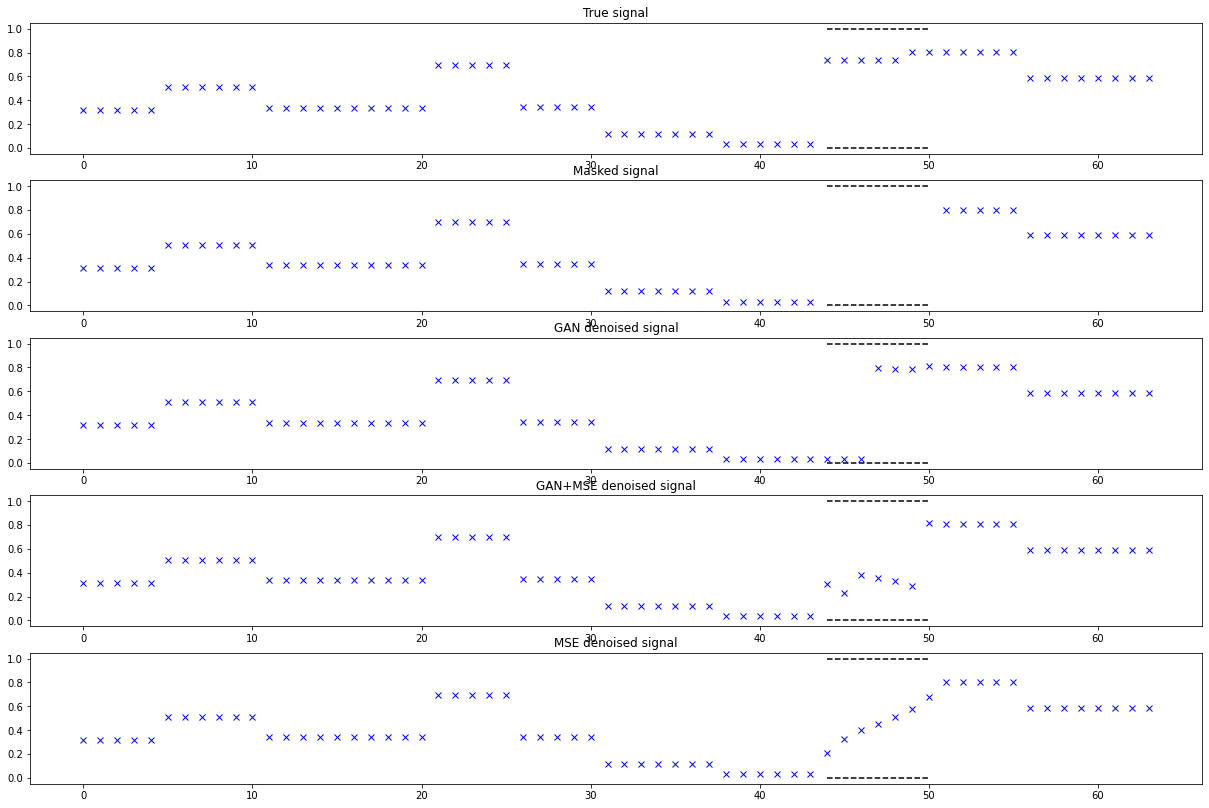

In [58]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)

Mask Length: 5	Mask Start: 57


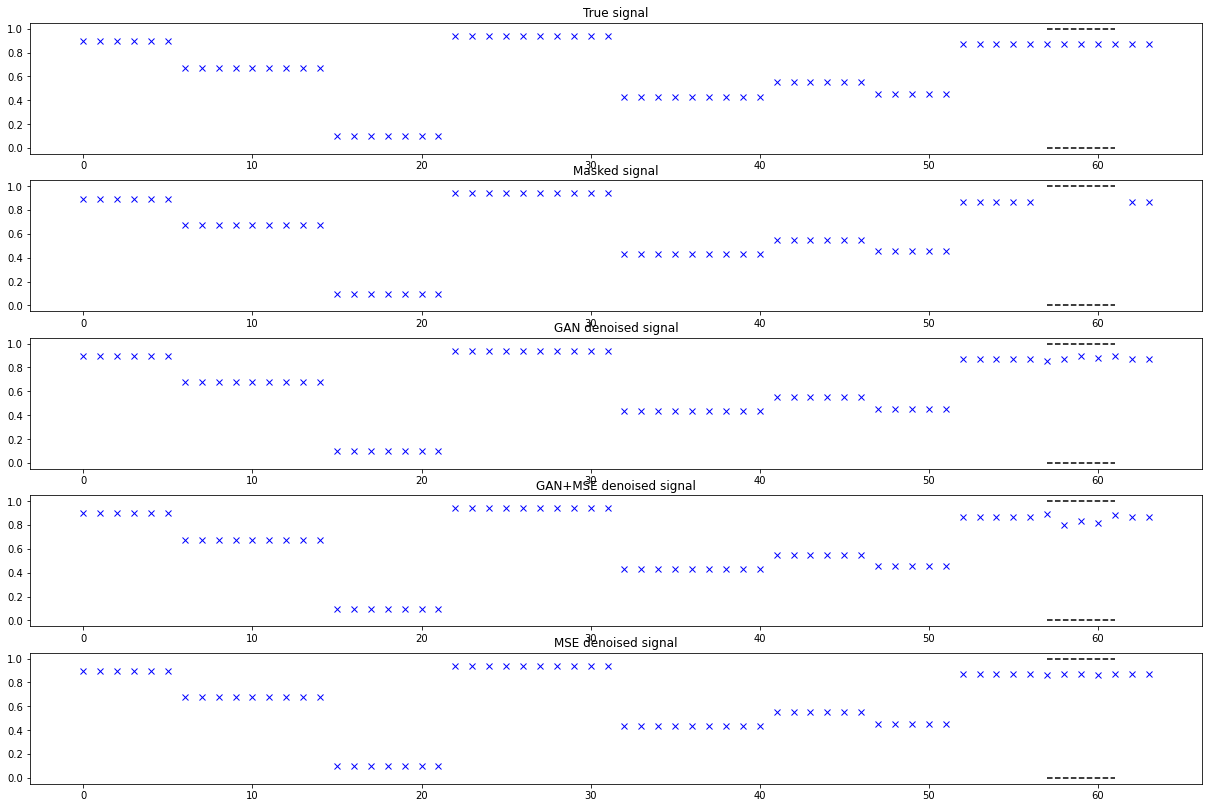

In [59]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)

Mask Length: 6	Mask Start: 39


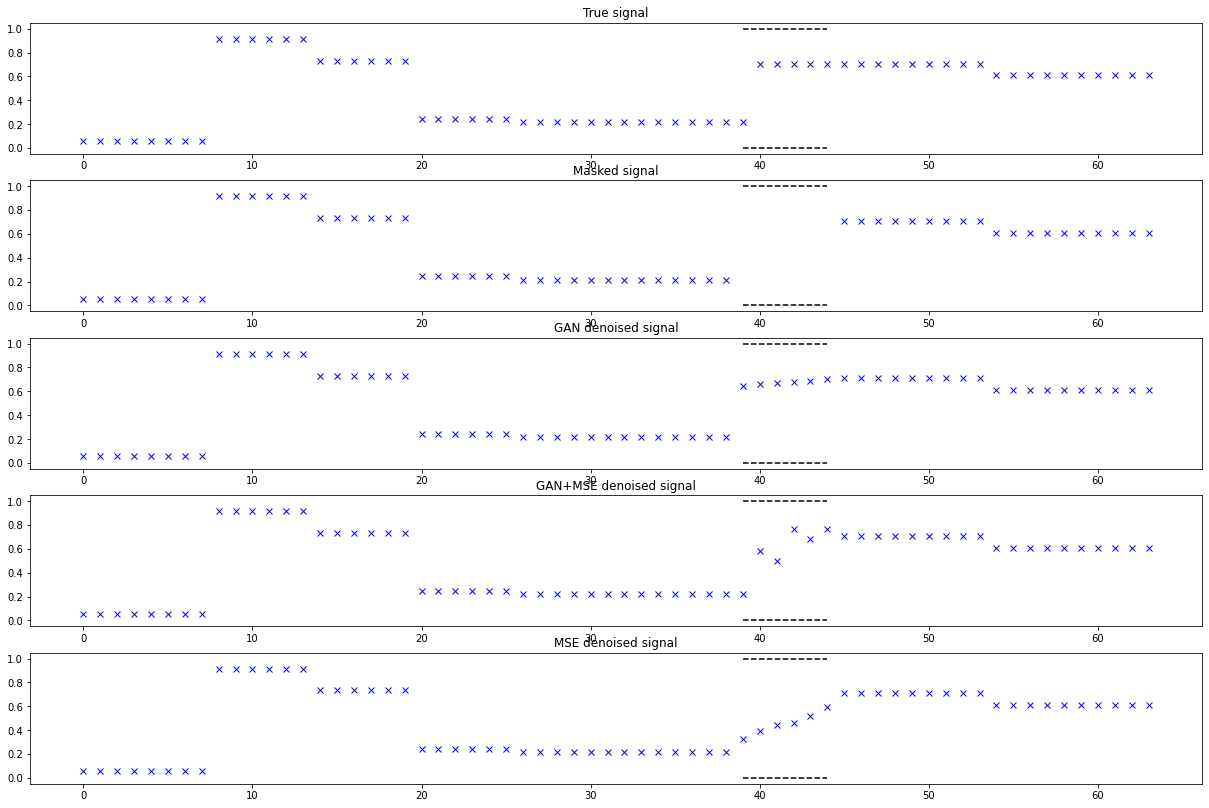

In [60]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)

Mask Length: 5	Mask Start: 45


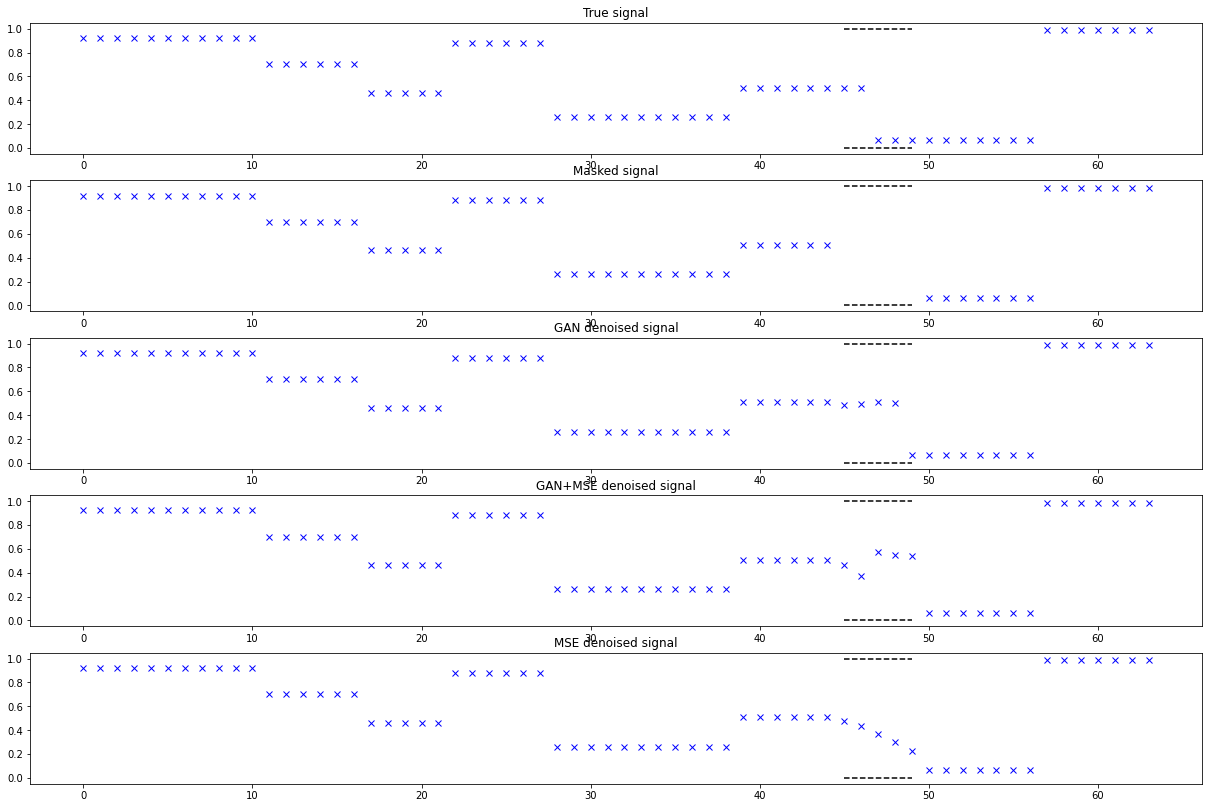

In [61]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)

Mask Length: 9	Mask Start: 38


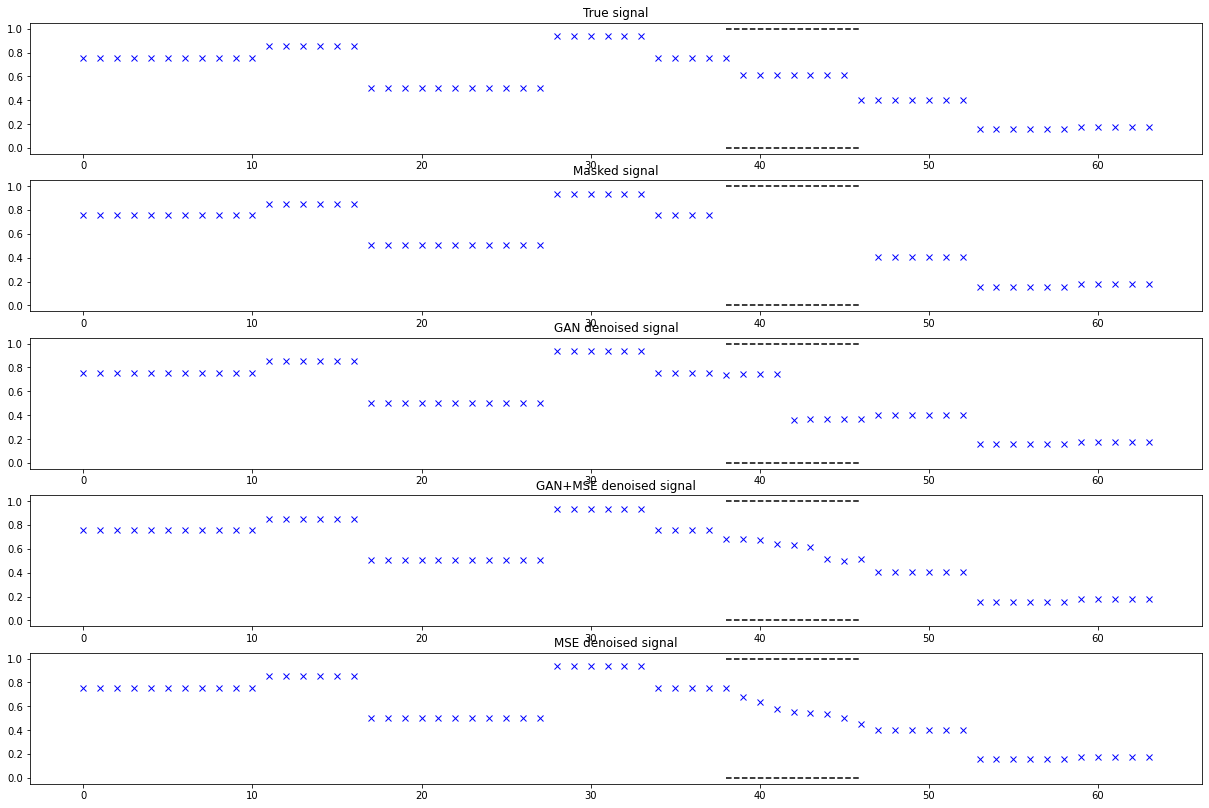

In [62]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)

Mask Length: 6	Mask Start: 9


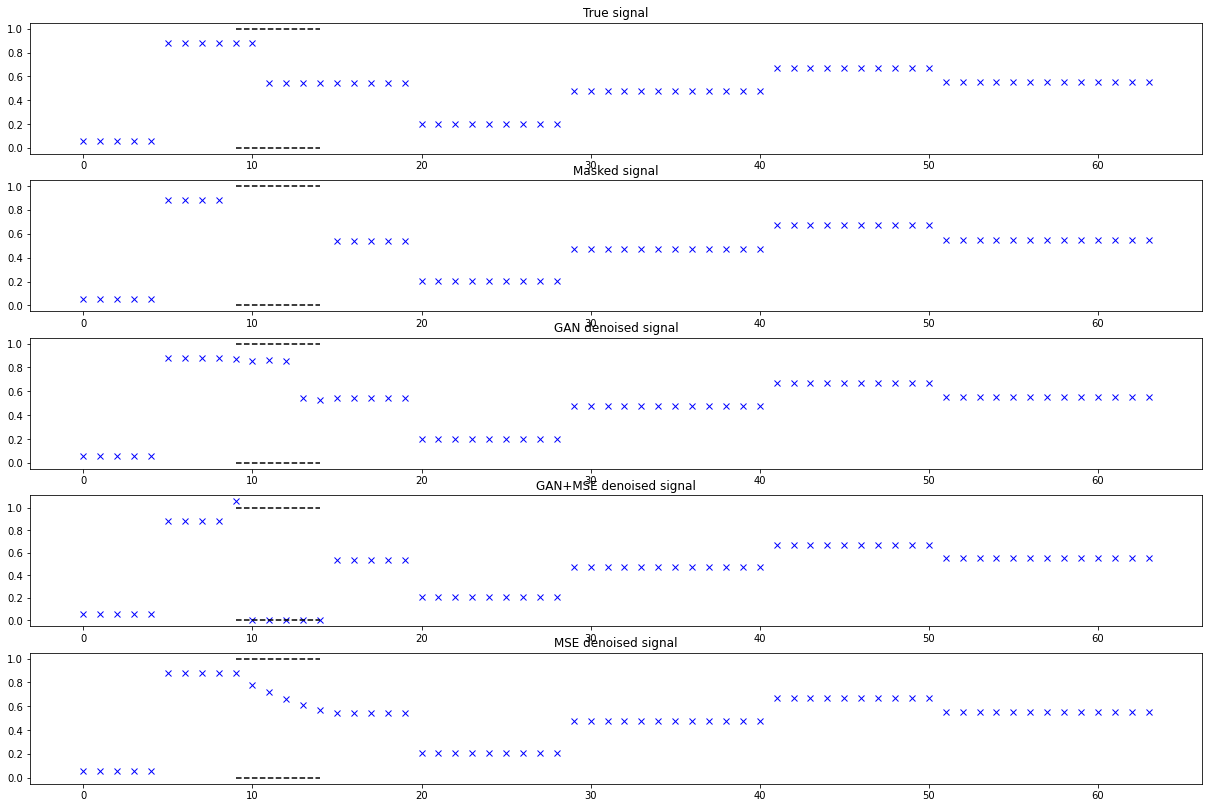

In [63]:
print_one(test_loader,netG_GAN,netG_GANMSE,netMSE)